# COMP-551 Mini-Project 1 Logistic Regression Page

# 1. Acquire, preprocess, and analyze the data




### 1.1 Acquire Data 


In [ ]:
!mkdir folder-qb
!curl --output "Qualitative_Bankruptcy%20(250%20instances).rar" "https://archive.ics.uci.edu/ml/machine-learning-databases/00281/Qualitative_Bankruptcy%20(250%20instances).rar"
!unrar e "Qualitative_Bankruptcy%20(250%20instances).rar"



mkdir: cannot create directory ‘folder-qb’: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3610  100  3610    0     0  51571      0 --:--:-- --:--:-- --:--:-- 50845

UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from Qualitative_Bankruptcy%20(250%20instances).rar


Would you like to replace the existing file Qualitative_Bankruptcy.arff
  6663 bytes, modified on 2014-03-14 16:07
with a new one
  6663 bytes, modified on 2014-03-14 16:07

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit y

Extracting  Qualitative_Bankruptcy.arff                                   47%  OK 

Would you like to replace the existing file Qualitative_Bankruptcy.data.txt
  3893 bytes, modified on 2014-03-14 15:38
with a new one
  3893 bytes, modified on 2014-03-14 15:38

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit y

Extracting  Qualitative

In [ ]:
#### Import Relevant Files
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import copy

# sb.pairplot(datafram)

In [ ]:

qb = pd.read_csv('Qualitative_Bankruptcy.data.txt', header=None, names=['Industrial Risk', 
                                                                        'Management Risk',
                                                                        'Financial Stability',
                                                                        'Credibility',
                                                                        'Competitiveness',
                                                                        'Operating Risk',
                                                                        'Class']) 

## 1.2 Preprocess Data
### 1.2.1 Qualitative Bankruptcy Dataset


There are no missing values/data so there is no need to drop anything. 



Swap the B and NB response data to a binary 1 or 0 for easier classification.

In [ ]:
for value in qb.columns:
  qb[value] = qb[value].replace({'NB' : 0, 'B' : 1})

Use one-hot encoding to turn categorical data into numerical ones. Also put class to the front for consistency. Due to one-hot encoding with all categorical values being in sets of 3, there is no need to normalise data.

In [ ]:
class_collumn = qb.iloc[:,6]
rest_of_collumns = qb.iloc[:,:6]
data = pd.concat([class_collumn, rest_of_collumns], axis=1)


one_hot = pd.get_dummies(data, columns = ['Industrial Risk', 
                                        'Management Risk',
                                        'Financial Stability',
                                        'Credibility',
                                        'Competitiveness',
                                        'Operating Risk'])


### Correlation between features and outputs
We wanted to observe how certain features of the Qualitative Bankruptcy dataset affect the final results. Using corr() we are able to determine which features seem to have a stronger correlation.

In [ ]:
#check the correlation 
print(one_hot.corr()['Class'])

Class                    1.000000
Industrial Risk_A       -0.115183
Industrial Risk_N        0.251705
Industrial Risk_P       -0.142803
Management Risk_A       -0.118131
Management Risk_N        0.357219
Management Risk_P       -0.290834
Financial Stability_A   -0.490059
Financial Stability_N    0.826646
Financial Stability_P   -0.450823
Credibility_A           -0.279406
Credibility_N            0.780553
Credibility_P           -0.535782
Competitiveness_A       -0.387186
Competitiveness_N        0.967690
Competitiveness_P       -0.654404
Operating Risk_A        -0.007631
Operating Risk_N         0.246848
Operating Risk_P        -0.257562
Name: Class, dtype: float64


### We then decided to drop the attributes with a correlation between -0.5 and 0.5. In order to remove irrelevant data from the dataset.

In [ ]:
#data set with corr between -0.5 and 0.5 dropped
one_hot_corr_dropped = one_hot.loc[:,['Class', 'Financial Stability_N', 'Credibility_N', 'Credibility_P', 'Competitiveness_N', 'Competitiveness_P']]




## 1.3 Analyze Data
### 1.3.1 What are the distributions of the positive vs. negative classes?

In [ ]:
N = len(one_hot)
bankruptc = one_hot['Class'].sum()
not_bankruptc = N - bankruptc
percentage_b = (bankruptc/N) * 100.0
percentage_nb = (not_bankruptc/N) * 100.0

print("From a total of " + str(N) + " values, " + str(bankruptc) + " are negative/bankrupt which is " + 
      str(percentage_b) + "% of the total while " + str(not_bankruptc) + " are positive/not bankrupt which is " + str(percentage_nb) + "% of the total.")

From a total of 250 values, 107 are negative/bankrupt which is 42.8% of the total while 143 are positive/not bankrupt which is 57.199999999999996% of the total.


#2. Implementation of the logistical regression

Here we have 2 classes, one for the gradient descent and one for the logistic regression.

In [ ]:
logistic = lambda z: 1./ (1 + np.exp(-z))       #logistic function

class LogisticRegression:

  def __init__(self, add_bias=True):
    self.add_bias = add_bias
 

  def fit(self, x, y, optimizer):

    if x.ndim == 1:
      x = x[:, None]

    if self.add_bias:
      N = x.shape[0]
      x = np.column_stack([x, np.ones(N)])
    
    N, D = x.shape
    def gradient(x, y, w, lambdaa):
        N,D = x.shape
        yh = logistic(np.dot(x, w))    # predictions  size N
        grad = np.dot(x.T, yh - y)/N      # divide by N because cost is mean over N points
        grad[1:] += lambdaa * w[1:]       
        return grad  
    w0 = np.zeros(D)
    optimizer.run(gradient, x, y, w0)

    return self

  def predict(self, x, w):
    if x.ndim == 1:
      x = x[:, None]
    Nt = x.shape[0]
    if self.add_bias:
      x = np.column_stack([x, np.ones(Nt)])
    yh = logistic(np.dot(x, w))

    return yh


In [ ]:
class GradientDescent:
    #if batch_size is 0, its full batch
    def __init__(self, weight, learning_rate=.01, max_iters=1e6, epsilon=1e-8, record_history=True, lambdaa = 0.01, verbose=False, batch_size=0):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        self.verbose = verbose
        self.weight = weight
        self.lambdaa = lambdaa
        self.batch_size = batch_size
        self.w_history = []                 #to store the weight history for visualization
        self.cost_history = []
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1

        if self.batch_size != 0:
          numSamples = x.shape[0]

          # Seperates indices into mini-batches
          numBatches =  numSamples // self.batch_size if numSamples > self.batch_size else  1
          mini_batches_indices = np.array_split(np.arange(numSamples), numBatches)

          while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            y = np.array(y)
            for batch in mini_batches_indices:
                mini_x, mini_y = (x[batch, :], y[batch])

                grad = gradient_fn(mini_x, mini_y, w, self.lambdaa)  # compute the gradient with present weight
                w = w - (self.learning_rate) * grad  # weight update step
                t += 1

            if self.record_history:
                self.w_history.append(w)
                z = np.dot(x,w) #N x 1
                J = np.mean( y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)) )
                self.cost_history.append(J)

            t += 1            
        else:
          while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
              grad = gradient_fn(x, y, w, self.lambdaa)               # compute the gradient with present weight
              w = w - (self.learning_rate) * grad         # weight update step
              if self.record_history:
                  self.w_history.append(w)
                  z = np.dot(x,w) #N x 1
                  J = np.mean( y * np.log1p(np.exp(-z)) + (1-y) * np.log1p(np.exp(z)) )
                  self.cost_history.append(J)
              t += 1
        self.weight = w
        if self.verbose:
          print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(grad)}')
          print(f'the weight found: {w}')    
        return w

# 3. Run Experiments

### Split each dataset into training, and test sets. Use test set to estimate performance in all of the experiments after training the model with training set. Evaluate the performance using the corresponding cost function for the classification


## 3.1 Report the performance of fully batched logistic regression. For both datasets use a 80/20 train/test split and report the performance on both training set and test set.


In [ ]:
from pandas import DataFrame
#we assume class is first 
def splitSets(df: DataFrame, TRAIN_SET_PERCENTAGE=0.8, VALIDATION_SET_PERCENTAGE=0) -> None:

  dataset = df.to_numpy()
  # Ensure positive and negative classes are split evenly by randomizing the order
  indp = np.random.permutation(dataset)

  # Get the x and y from the dataset
  n,d = indp.shape
  x, y = indp[:,1:d], indp[:,0]

  # Find indices to split at
  TRAIN_SPLIT_AMT = round(TRAIN_SET_PERCENTAGE*len(df))
  VAL_SPLIT_AMT = TRAIN_SPLIT_AMT + round(VALIDATION_SET_PERCENTAGE*len(df))

  # Training set data 
  x_train = x[:TRAIN_SPLIT_AMT]

  # Training set column
  y_train = y[:TRAIN_SPLIT_AMT]

    # Validation set data
  x_validation = x[TRAIN_SPLIT_AMT:VAL_SPLIT_AMT]
  
  # Validation set column
  y_validation = y[TRAIN_SPLIT_AMT:VAL_SPLIT_AMT]

    # Test set data
  x_test = x[VAL_SPLIT_AMT:]

  # Test set column
  y_test = y[VAL_SPLIT_AMT:]

  return x_train, y_train, x_validation, y_validation, x_test, y_test


  
def get_mean_abs_error(train, pred):

  return np.mean(np.abs(train - pred))


def mean_cross_entropy_error(y_true, y_pred):
    """
    This function calculates cross-entropy loss
    :param y_true: list of real numbers, true values
    :param y_pred: list of real numbers, predicted values
    :returns: mean cross-entropy loss
    """
    return np.mean( y_true * np.log1p(np.exp(-y_pred)) + (1-y_true) * np.log1p(np.exp(y_pred)) )


toy test of 1 feature based on our model with cost function mean value of whole model.

terminated after 67072 iterations, with norm of the gradient equal to 9.999864847809292e-05
the weight found: [-0.70181248  0.11116726 -0.40006062 -0.21995369  0.21964043 -0.30496411
 -0.82239411  1.23362227 -0.71650552 -0.40814022  1.04671089 -0.94384803
 -0.81120535  2.02264716 -1.51671918  0.02783143  0.00665595 -0.33976474
 -0.30527736]


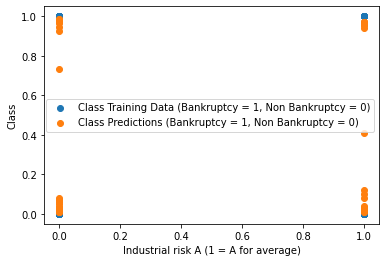

0.04601549943393345
0.5840318754644539


In [ ]:
x_training, y_training, x_validation, y_validation, x_test, y_test = splitSets(one_hot)
optimizer1 = GradientDescent(0,record_history=True, verbose=True,epsilon=1e-4, max_iters=1e5)
model1 = LogisticRegression()
predictedClass = model1.fit(x_training,y_training, optimizer1).predict(x_test,optimizer1.weight)

errorClass = get_mean_abs_error(y_test, predictedClass)
errorClassCE = mean_cross_entropy_error(y_test, predictedClass)



plt.scatter(x_test[:,0], y_test, label="Class Training Data (Bankruptcy = 1, Non Bankruptcy = 0)")
plt.scatter(x_test[:,0], predictedClass, label="Class Predictions (Bankruptcy = 1, Non Bankruptcy = 0)")
plt.xlabel('Industrial risk A (1 = A for average)')
plt.ylabel('Class')
plt.legend()
plt.show()

print(errorClass)
print(errorClassCE)


### Cost over time

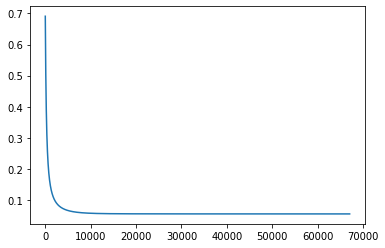

In [ ]:
time = np.linspace(0, len(optimizer1.cost_history), len(optimizer1.cost_history))

plt.plot(time,optimizer1.cost_history)

terminated after 76155 iterations, with norm of the gradient equal to 9.999670883502072e-05
the weight found: [-1.12623393  0.06858133 -0.32488616 -0.10610412  0.20888759 -0.37555827
 -0.86715707  1.26916706 -0.67478479 -0.38902576  1.05291046 -0.9366595
 -0.74967142  1.98642251 -1.50952589  0.04784388  0.01504014 -0.33565882
 -0.2727748 ]


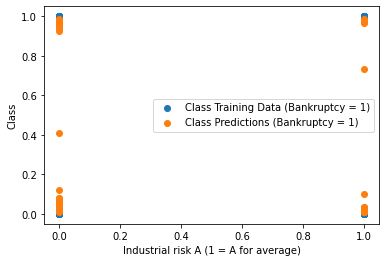

0.0514887806369562
0.5487026191470673


In [ ]:
x_training, y_training, x_validation, y_validation, x_test, y_test = splitSets(one_hot)

optimizer2 = GradientDescent(0,record_history=True, verbose=True,epsilon=1e-4, max_iters=1e5)
model2 = LogisticRegression()
predictedClass2 = model2.fit(x_training,y_training, optimizer2).predict(x_training,optimizer2.weight)

errorClass = get_mean_abs_error(y_training, predictedClass2)
errorClassCE = mean_cross_entropy_error(y_training, predictedClass2)


plt.scatter(x_test[:,0], y_test, label="Class Training Data (Bankruptcy = 1)")
plt.scatter(x_test[:,0], predictedClass, label="Class Predictions (Bankruptcy = 1)")
plt.xlabel('Industrial risk A (1 = A for average)')
plt.ylabel('Class')
plt.legend()
plt.show()

print(errorClass)
print(errorClassCE)


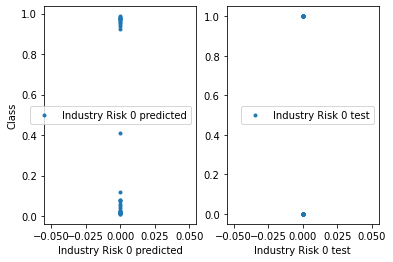

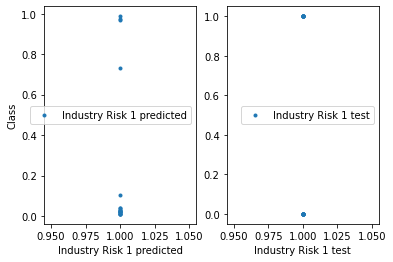

In [ ]:
#helper function to get all the rows with a certain value !!! does not work if selecting for y predicted (only for exact matching)
def get_only_category(data, index_of_data, category, response):
  mask = (data[:, index_of_data] == category)
  cat_data = data[mask, index_of_data]
  resp_data = data[mask, response]
  return np.append(cat_data[:, None],resp_data[:, None],1)

predicted_data = np.append(x_test,predictedClass[:, None],1)
testing_data = np.append(x_test,y_test[:, None],1)

IndRisk0_predicted = get_only_category(predicted_data,0,0,18)
IndRisk0_test = get_only_category(testing_data,0,0,18)

IndRisk1_predicted = get_only_category(predicted_data,0,1,18)
IndRisk1_test = get_only_category(testing_data,0,1,18)


plt.subplot(1, 2, 1)
plt.scatter(IndRisk0_predicted[:,0], IndRisk0_predicted[:,1], label="Industry Risk 0 predicted", marker=".")
plt.xlabel('Industry Risk 0 predicted')
plt.ylabel('Class')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(IndRisk0_test[:,0], IndRisk0_test[:,1], label="Industry Risk 0 test", marker=".")
plt.xlabel('Industry Risk 0 test')
plt.legend()
plt.show()

plt.subplot(1, 2, 1)
plt.scatter(IndRisk1_predicted[:,0], IndRisk1_predicted[:,1], label="Industry Risk 1 predicted", marker=".")
plt.xlabel('Industry Risk 1 predicted')
plt.ylabel('Class')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(IndRisk1_test[:,0], IndRisk1_test[:,1], label="Industry Risk 1 test", marker=".")
plt.xlabel('Industry Risk 1 test')
plt.legend()
plt.show()




## 3.2 Report the weights of each of features in your trained models and discuss how each feature could affect the performance of the models.


In [ ]:
import pandas as pd
weights = pd.DataFrame(one_hot.iloc[0])
weights.rename({"Class":"Bias"}, axis='index', inplace=True)
weights_df = pd.DataFrame(optimizer1.weight)
n,m = weights_df.shape
for i in weights_df.T:
  weights.iloc[i,0] = weights_df.iloc[i,0]

print(weights)


                              0
Bias                  -0.925084
Industrial Risk_A      0.120595
Industrial Risk_N     -0.399471
Industrial Risk_P     -0.180738
Management Risk_A      0.170505
Management Risk_N     -0.285285
Management Risk_P     -0.848473
Financial Stability_A  1.248269
Financial Stability_N -0.695314
Financial Stability_P -0.400624
Credibility_A          1.059146
Credibility_N         -0.954040
Credibility_P         -0.739209
Competitiveness_A      1.981159
Competitiveness_N     -1.537469
Competitiveness_P      0.076099
Operating Risk_A       0.001114
Operating Risk_N      -0.372731
Operating Risk_P      -0.295519


## 3.3 Sample growing subsets of the training data (20%,30%,...80%). Observe and explain how does size of training data affects the performance for both models. Plot two curves as a function of training size, one for performance in train and one for test

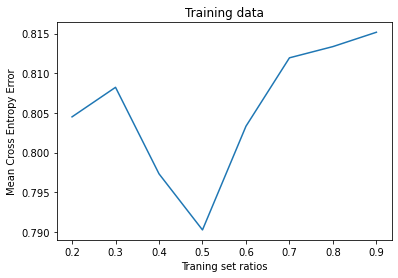

In [ ]:
def plotPerformanceLog(model, data, trainSetRatio=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],learningRate=0.1, trainingData = True, lr=False):
    performanceCl = []
    for ratio in trainSetRatio:
        x_train, y_train, x_validation, y_validation, x_test, y_test = splitSets(data, TRAIN_SET_PERCENTAGE=ratio)

        gradientDescent = GradientDescent(0, learning_rate=learningRate)
        LR = model
        if trainingData:
          predictedClass = LR.fit(x_train, y_train,gradientDescent).predict(x_train,gradientDescent.weight)
          meanCrossEntropyErr = mean_cross_entropy_error(x_train.T, predictedClass)
        else:
          predictedClass = LR.fit(x_train, y_train,gradientDescent).predict(x_test,gradientDescent.weight)
          meanCrossEntropyErr = mean_cross_entropy_error(x_test.T, predictedClass)

        performanceCl.append(meanCrossEntropyErr)

    if lr:
      plt.plot(np.array(trainSetRatio), np.array(performanceCl), label=('Logistical Gradient Descent with learning rate ' + str(learningRate)))
    else: 
      plt.plot(np.array(trainSetRatio), np.array(performanceCl), label=('Logistical Gradient Descent'))



def plotPerformanceBatched(model,data, trainSetRatio=0.8, batchSize=8, learningRate=0.1, trainingData = True, lr=False):
    performanceCl = []
    x_train, y_train, x_validation, y_validation, x_test, y_test = splitSets(data, TRAIN_SET_PERCENTAGE=trainSetRatio)
  
    gradientDescent = GradientDescent(0, batch_size=batchSize)
    LR = model


    if trainingData:
      predictedClass = LR.fit(x_train, y_train,gradientDescent).predict(x_train,gradientDescent.weight)
      meanCrossEntropyErr = mean_cross_entropy_error(x_train.T, predictedClass)
    else:
      predictedClass = LR.fit(x_train, y_train,gradientDescent).predict(x_test,gradientDescent.weight)
      meanCrossEntropyErr = mean_cross_entropy_error(x_test.T, predictedClass)
       
    performanceCl.append(meanCrossEntropyErr)


    if lr:
      plt.scatter(len(gradientDescent.w_history), np.array(performanceCl), label=('Logistical Gradient Descent with learning rate ' + str(learningRate)))
    else: 
      plt.scatter(len(gradientDescent.w_history), np.array(performanceCl), label=('Logistical Gradient Descent with mini-batch size ' + str(batchSize)))


plotPerformanceLog(LogisticRegression(), one_hot)
plt.xlabel('Traning set ratios')
plt.ylabel('Mean Cross Entropy Error')
plt.title('Training data')
#plotPerformanceSGD(LinearRegressionOptimized(), batchSize=64)
#plt.legend()
plt.show()



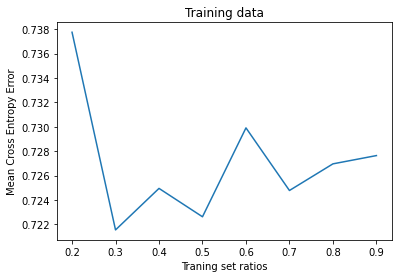

In [ ]:
plotPerformanceLog(LogisticRegression(), one_hot_corr_dropped)
plt.xlabel('Traning set ratios')
plt.ylabel('Mean Cross Entropy Error')
#plotPerformanceSGD(LinearRegressionOptimized(), batchSize=64)
#plt.legend()
plt.title('Training data')
plt.show()

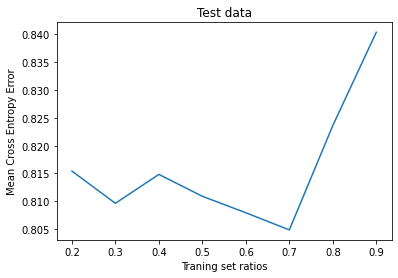

In [ ]:
plotPerformanceLog(LogisticRegression(), one_hot, trainingData=False)
plt.xlabel('Traning set ratios')
plt.ylabel('Mean Cross Entropy Error')
plt.title('Test data')
#plotPerformanceSGD(LinearRegressionOptimized(), batchSize=64)
#plt.legend()
plt.show()


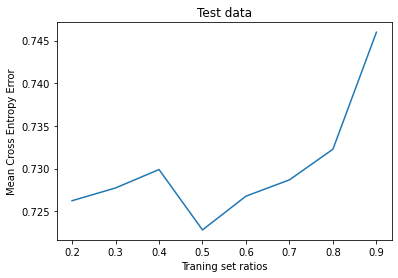

In [ ]:
plotPerformanceLog(LogisticRegression(), one_hot_corr_dropped, trainingData=False)
plt.xlabel('Traning set ratios')
plt.ylabel('Mean Cross Entropy Error')
#plotPerformanceSGD(LinearRegressionOptimized(), batchSize=64)
#plt.legend()
plt.title('Test data')
plt.show()

## 3.4 For both linear and logistic regression, try out growing minibatch sizes, e.g., 8, 16, 32, 64, and 128. Compare the convergence speed and final performance of different batch sizes to the fully batched baseline. Which configuration works the best among the ones you tried?

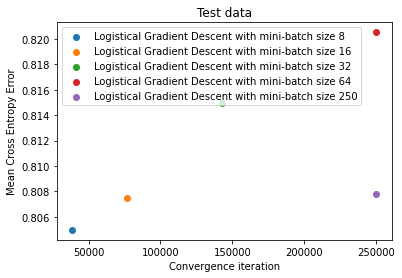

In [ ]:
batch = 4
for i in range(4):
  batch = batch * 2   
  plotPerformanceBatched(LogisticRegression(),one_hot, batchSize=batch, lr=False)

#fully batched n=250
plotPerformanceBatched(LogisticRegression(),one_hot,batchSize=250, lr=False)

plt.xlabel('Convergence iteration')
plt.ylabel('Mean Cross Entropy Error')
plt.title('Test data')
plt.legend()
plt.show()

## 3.5 Present the performance of both linear and logistic regression with at least three different learning rates (your own choice).

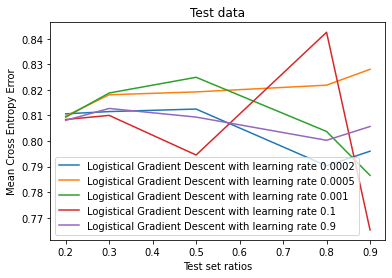

In [ ]:
lr = [0.0002, 0.0005, 0.001, 0.1, 0.9]

for i in range(len(lr)):
  plotPerformanceLog(LogisticRegression(),one_hot,trainingData=False, learningRate=lr[i], lr=True)

plt.xlabel('Test set ratios')
plt.ylabel('Mean Cross Entropy Error')
plt.title('Test data')
plt.legend()
plt.show()


## 3.6 Compare analytical linear regression solution with mini-batch stochastic gradient descent based linear regression solution. What do you find?
